In [1]:
#Follows heavily the pytorch classification tutorial

In [2]:
import os
import csv
import numpy as np
import math
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image
from tqdm import tqdm
#import argparse

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.utils import save_image

matplotlib.style.use('ggplot')

torch.cuda.empty_cache() 
#import model

In [3]:
class Encoder(nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__() 
        self.enc1 = nn.Conv2d(
            in_channels=3, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_kernel, out_channels=init_kernel*2, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_kernel*2, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_kernel*4, out_channels=init_kernel*8, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc5 = nn.Conv2d(
            in_channels=init_kernel*8, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        #self.dropout = nn.Dropout2d(p=0.1) # need to call in forward but turn off automatically in eval()
        
        self.mu = nn.Linear(init_kernel*191*191, z_dim)
        self.sigma = nn.Linear(init_kernel*191*191, z_dim)
        
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
 
    def forward(self, x):
        
        #print("before anything")
        #print(x.shape)
        x = self.enc1(x)
        x = F.relu(x)
        x = self.enc2(x)
        x = F.relu(x)
        x = self.enc3(x)
        x = F.relu(x)
        #x = self.enc4(x)
        #x = F.relu(x)
        #x = self.enc5(x)
        #x = F.relu(x)
        
        #print("before flatten:")
        #print(x.shape)
        
        x = x.view(x.size(0), -1)
        
        #print("after flatten:")
        #print(x.shape)
        
        # get `mu` and `log_var`
        mu = self.mu(x)
        log_var = self.sigma(x) # fix!!!!name
        
        #return mu, log_var #fix!!! name
        ## get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        
        return z, mu, log_var

class Decoder(nn.Module):
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        
        self.lin1 = nn.Linear(z_dim, init_kernel*191*191)
        
        self.dec1 = nn.ConvTranspose2d(
            in_channels=init_kernel, out_channels=init_kernel*8, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_kernel*8, out_channels=init_kernel*4, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_kernel, out_channels=init_kernel*2, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_kernel*2, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec5 = nn.ConvTranspose2d(
            in_channels=init_kernel, out_channels=3, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        
    def forward(self, z):
        x = self.lin1(z)
        x=F.relu(x)
        
        x=x.view(-1, init_kernel, 191, 191)
        #print("after unflatten:")
        #print(x.shape)
        
        #x = self.dec1(x)
        #x = F.relu(x)
        #x = self.dec2(x)
        #x = F.relu(x)
        x = self.dec3(x)
        x = F.relu(x)
        x = self.dec4(x)
        x = F.relu(x)
        x = self.dec5(x)
        reconstruction = torch.sigmoid(x)
        
        return reconstruction

class ConvVAE(nn.Module):
    def __init__(self, z_dim):
        super(ConvVAE, self).__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
    
    def forward(self,x):
        sample, z_mu, z_logvar = self.encoder(x)
        #z_mu, z_logvar = self.encoder(x)
        
        #std = torch.exp(z_logvar)
        #eps = torch.randn_like(std) # `randn_like` as we need the same size
        #sample = z_mu + (eps * std) # sampling
        
        reconstruction = self.decoder(sample)
        
        return reconstruction, z_mu, z_logvar

Below should be the optimal paramters

In [4]:
epochs = 25 # 50,100
batch_size = 1 #8,16,32,64?
lr = 0.0001 #0.002, 0.003

kernel_size = 4 #3,4,5,6?
stride = 1 #1,2,3,4?
padding = 0 #0,1,2,3,4?
init_kernel = 8 #4,8,16,32 #initial number of filters

latent_dim = 96

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
class ActiveVisionDataset (Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file, index_col=None)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self,index):
        if type(index) == torch.Tensor:
            index = index.item()
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        shape_label = torch.tensor(int(self.annotations.iloc[index,1]))
        cam_loc = torch.tensor(ast.literal_eval(self.annotations.iloc[index,2]))
        
        if self.transform:
            image = self.transform(image)
        
        return image, shape_label, cam_loc

In [6]:
dataset = ActiveVisionDataset(csv_file='imgs/rgbCSV.csv', root_dir= 'imgs/rgbImg/', transform = torchvision.transforms.ToTensor())
train_data, val_data = torch.utils.data.random_split(dataset, [2400, 600])
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)

## Classification

In [7]:
classes = ['Shape 0', 'Shape 1', 'Shape 2', 'Shape 3', 'Shape 4', 'Shape 5']

In [8]:

classes = ['Shape 0', 'Shape 1', 'Shape 2', 'Shape 3', 'Shape 4', 'Shape 5']

# functions to show an image


def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

'''
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))
'''

"\n# get some random training images\ndataiter = iter(train_loader)\nimages, labels = dataiter.next()\n\n# show images\nimshow(torchvision.utils.make_grid(images))\n# print labels\nprint(' '.join('%5s' % classes[labels[j]] for j in range(8)))\n"

In [9]:
#Which model am i tryna load in huh
PATH = os.path.join(os.getcwd(), "outputs", "batch_sizes8", "batch_sizes8.pth")

ConvVAE = ConvVAE(latent_dim)#.to(device)
ConvVAE.load_state_dict(torch.load(PATH))
ConvVAE.to(device)

ConvVAE(
  (encoder): Encoder(
    (enc1): Conv2d(3, 8, kernel_size=(4, 4), stride=(1, 1))
    (enc2): Conv2d(8, 16, kernel_size=(4, 4), stride=(1, 1))
    (enc3): Conv2d(16, 8, kernel_size=(4, 4), stride=(1, 1))
    (enc4): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
    (enc5): Conv2d(64, 8, kernel_size=(4, 4), stride=(1, 1))
    (mu): Linear(in_features=291848, out_features=96, bias=True)
    (sigma): Linear(in_features=291848, out_features=96, bias=True)
  )
  (decoder): Decoder(
    (lin1): Linear(in_features=96, out_features=291848, bias=True)
    (dec1): ConvTranspose2d(8, 64, kernel_size=(4, 4), stride=(1, 1))
    (dec2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(1, 1))
    (dec3): ConvTranspose2d(8, 16, kernel_size=(4, 4), stride=(1, 1))
    (dec4): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(1, 1))
    (dec5): ConvTranspose2d(8, 3, kernel_size=(4, 4), stride=(1, 1))
  )
)

In [10]:
ConvVAE.eval()

ConvVAE(
  (encoder): Encoder(
    (enc1): Conv2d(3, 8, kernel_size=(4, 4), stride=(1, 1))
    (enc2): Conv2d(8, 16, kernel_size=(4, 4), stride=(1, 1))
    (enc3): Conv2d(16, 8, kernel_size=(4, 4), stride=(1, 1))
    (enc4): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
    (enc5): Conv2d(64, 8, kernel_size=(4, 4), stride=(1, 1))
    (mu): Linear(in_features=291848, out_features=96, bias=True)
    (sigma): Linear(in_features=291848, out_features=96, bias=True)
  )
  (decoder): Decoder(
    (lin1): Linear(in_features=96, out_features=291848, bias=True)
    (dec1): ConvTranspose2d(8, 64, kernel_size=(4, 4), stride=(1, 1))
    (dec2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(1, 1))
    (dec3): ConvTranspose2d(8, 16, kernel_size=(4, 4), stride=(1, 1))
    (dec4): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(1, 1))
    (dec5): ConvTranspose2d(8, 3, kernel_size=(4, 4), stride=(1, 1))
  )
)

In [11]:
#            latent.extend(mu.cpu().numpy())
#            target.extend(labels.numpy())

#Should probably be a test set here!

def generate_latent_vectors(model, dataloader):
    model.eval()
    latent = []
    target = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, labels = data
            #if torch.cuda.is_available():
            #    data = data.to(device)
            z, mu, logvar = model.encoder(data.cuda())
            latent.extend(mu)
            target.extend(labels)
        return latent, target

In [12]:
train_latent_var, train_target = generate_latent_vectors(ConvVAE, train_loader)
test_latent_var, test_target = generate_latent_vectors(ConvVAE, val_loader)

2400it [00:06, 343.87it/s]                                                                                             
100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 434.57it/s]


In [13]:
#print(len(train_latent_var))
print(train_latent_var[0])
#train_latent_var = latent_var[0:60]
#test_latent_var = latent_var[60:75]
#print(len(train_latent_var))
#print(len(test_latent_var))

tensor([-0.5902, -0.7608, -0.2314,  0.6292,  0.5407,  0.3268,  0.7189, -0.6056,
         1.0313, -0.7886, -0.2300,  0.2419,  0.2733, -0.1038,  0.3910, -0.3768,
         1.1979,  0.2924, -0.9146,  0.5108, -0.6003,  0.1270,  0.9342, -0.1726,
         0.3737, -0.1945,  0.7326, -0.4094,  0.2962,  0.2717,  0.4465, -0.5386,
        -1.1835,  0.6970, -0.7199,  0.7713, -0.7353,  0.2939, -0.5259,  0.5331,
         0.9571,  0.4416,  0.3950, -0.7964, -0.1104, -0.0068,  0.5602, -0.4801,
        -0.4845,  0.0117, -0.1922,  0.1288,  0.3036,  1.4135, -0.3645,  0.6662,
         0.2392, -0.2018, -0.1202,  0.1856, -0.3293,  0.0741, -0.7557, -0.8053,
        -0.1886, -0.4724, -0.5213, -0.2918,  0.0432, -0.9366,  0.3105, -0.8509,
        -0.5471,  0.1135, -0.4119, -0.1082,  0.6108,  0.6970,  0.7552,  0.6603,
         0.2911, -0.9732,  0.6882,  0.2732, -0.1866,  0.6160, -0.7718,  0.1393,
         0.2422, -0.1818, -0.5264,  0.0867, -2.2872,  0.3984,  0.8484, -0.5999],
       device='cuda:0')


In [14]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.conv1 = nn.Conv2d(3, 6, 5)
        #self.pool = nn.MaxPool2d(2, 2)
        #self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(96, 60)
        #self.fc2 = nn.Linear(60, 30)
        self.fc3 = nn.Linear(60, 30)

    def forward(self, x):
        #x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, x.size(0))
        #print(x.shape)
        #print(x)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

Net(
  (fc1): Linear(in_features=96, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=30, bias=True)
)

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [16]:

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        _, labels = data
        z = train_latent_var[i].to(device)
        #print(z.shape)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        #if torch.cuda.is_available():
        #    z = z.to(device)

        # forward + backward + optimize
        outputs = net(z)
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

print('Finished Training')

Finished Training


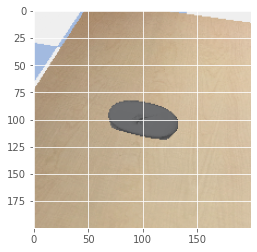

GroundTruth:  Shape 0


In [18]:
dataiter = iter(val_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(1)))

In [19]:
#for i in range(0,8):
#    outputs = net(test_latent_var[i])

In [21]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(1)))

Predicted:  Shape 1


In [22]:
correct = 0
total = 0
prediction = []
actual = []
with torch.no_grad():
    i = 0
    for data in val_loader:
        images, labels = data
        outputs = net(test_latent_var[i])
        _, predicted = torch.max(outputs.data, 1)
        prediction = prediction + predicted.tolist()
        actual = actual +labels.tolist()
        total += labels.size(0)
        correct += (predicted.cpu() == labels.cpu()).sum().item()
        i+=1
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 17 %


[1, 1, 1, 5, 2, 2, 2, 1, 2, 2, 1, 5, 5, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 5, 2, 1, 5, 5, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 5, 5, 2, 2, 2, 2, 1, 1, 5, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 4, 1, 5, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 5, 2, 1, 5, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 5, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 4, 2, 2, 1, 1, 2, 5, 1, 2, 1, 2, 2, 1, 5, 1, 1, 1, 2, 5, 1, 2, 2, 5, 2, 2, 1, 1, 2, 2, 5, 1, 5, 1, 1, 1, 2, 2, 5, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 5, 1, 1, 5, 2, 4, 1, 1, 1, 2, 5, 1, 1, 2, 2, 1, 2, 5, 2, 1, 2, 1, 2, 1, 2, 5, 2, 2, 1, 2, 1, 1, 1, 2, 5, 1, 2, 2, 2, 1, 2, 2, 1, 5, 1, 5, 5, 2, 2, 5, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 5, 5, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 5, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 4, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 

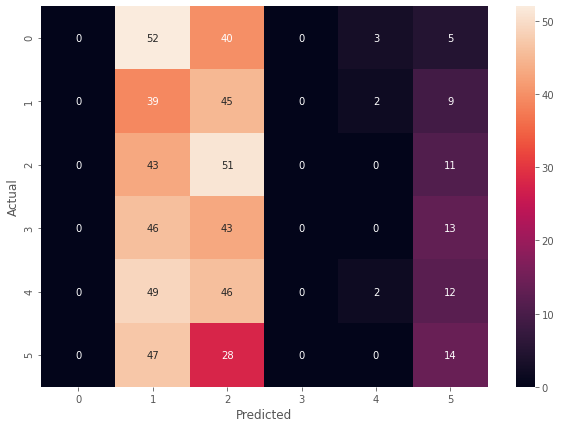

In [23]:
#print("prediction")
print(prediction)
#print(len(prediction))
#print("actual")
print(actual)
#print(len(actual))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual, prediction)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = [i for i in range(0,6)],
                  columns = [i for i in range(0,6)])
plt.figure(figsize = (10,7))

sn.heatmap(df_cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()